In [1]:
#Loading the libraries.
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Loading in scenario 10.
data = pd.read_csv("capture20110818.binetflow")

In [3]:
#Fixing the labels to appropriate values. Background->-1, Normal->0, Malicious->,1.
Labels = [] 
for i in data.Label.values:
    if re.search("Background",i)!=None:
        Labels.append(-1)
    elif re.search("Normal",i)!=None:
        Labels.append(0)
    elif re.search("Botnet",i)!=None:
        Labels.append(1)
data["Label"]=Labels
data.Label.unique()        

array([-1,  0,  1], dtype=int64)

In [4]:
#Creating new dataframe by removing background netflow data.
data_WB = data.loc[data["Label"]!=-1]

In [6]:
#Just run this twice to kill the annoying warning. Converting StartTime to a datetime variable. 
data_WB.loc[:,"StartTime"] = pd.to_datetime(data_WB["StartTime"])

In [7]:
#Count of missing values in the columns of the dataset.
countofnas=[]
for i in data_WB.columns:
    tf= data_WB[i].isna()
    countofna=0
    for j in tf.values:
        if j==True:
            countofna+=1
    countofnas.append(countofna)        
for i,j in zip(countofnas,data_WB.columns):
    if i!=0:
        print('Column name-'+str(j))
        print("Count of nas="+str(i)+"\n")            

Column name-Sport
Count of nas=27

Column name-Dport
Count of nas=101196

Column name-State
Count of nas=1227

Column name-sTos
Count of nas=29

Column name-dTos
Count of nas=107104



In [8]:
#We see that sTos and dTos are also useless. Better to get rid of it. 
data_WB.sTos.unique(),data_WB.dTos.unique()

(array([ 0., nan]), array([ 0., nan]))

In [9]:
#Due to large number of missing values, removing dTos and Dport as it will only cloud results. Removing sTos as it's useless.
data_WB_cleaned = data_WB.drop(columns=["dTos","Dport","sTos"])

In [10]:
# For the label encoding, replacing nans with default values for State and Sport and converting them to categorical. 
data_WB_cleaned.loc[data_WB['State'].isna(),'State'] = "UNK"
data_WB_cleaned.loc[data_WB['Sport'].isna(),'Sport'] = '0000'
data_WB_cleaned.loc[:,"Sport"]=data_WB_cleaned["Sport"].astype('category')
data_WB_cleaned.loc[:,"State"]=data_WB_cleaned["State"].astype('category')
data_vis=data_WB_cleaned.copy()

In [11]:
#Converting categorical variables in numerical ones using label encoder to be used for correlation. 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
categorical_columns=['Proto','Dir','SrcAddr','DstAddr',"State","Sport"]
for i in categorical_columns:
    data_WB_cleaned.loc[:,i] = le.fit_transform(data_WB_cleaned[i])

In [12]:
data_M = data_WB_cleaned.loc[data_WB_cleaned["Label"]==1] # This stores data on malicious netflows.
data_NM = data_WB_cleaned.loc[data_WB_cleaned["Label"]==0]# This stores data on normal netflows. 

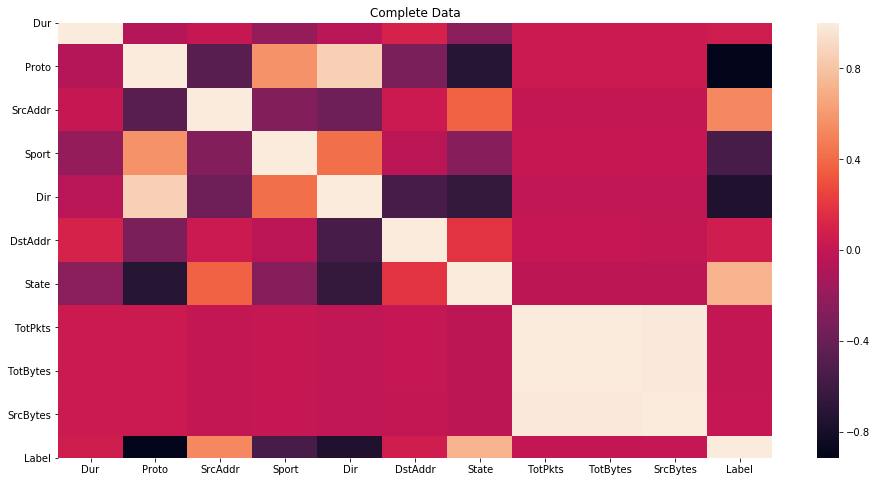

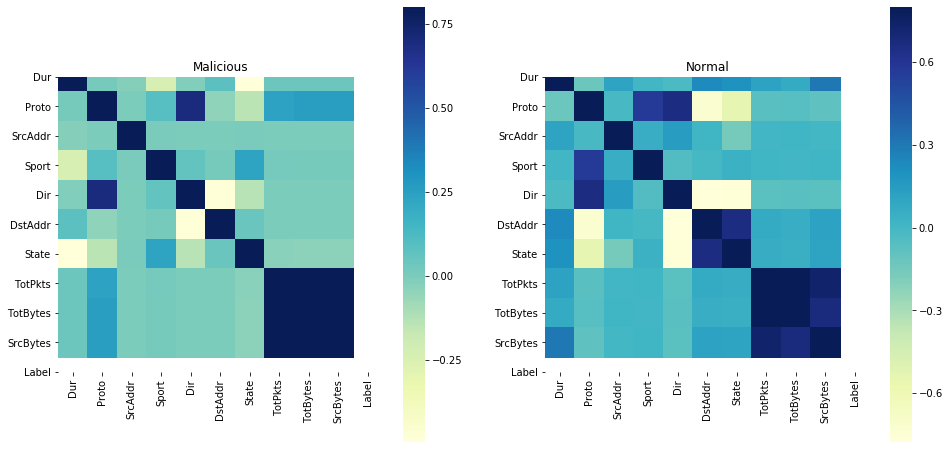

In [13]:
#correlation matrices
f, (ax1) = plt.subplots(1,figsize =(16, 8))
sns.heatmap(data_WB_cleaned.corr())
ax1.set_title('Complete Data')
plt.show()


f, (ax1, ax2) = plt.subplots(1,2,figsize =(16, 8))

sns.heatmap(data_M.corr(), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
ax1.set_title('Malicious')

sns.heatmap(data_NM.corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
ax2.set_title('Normal')

plt.show()

In [14]:
# I like the numbers yo!
data_WB_cleaned.corr()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,State,TotPkts,TotBytes,SrcBytes,Label
Dur,1.000000,-0.059651,0.019821,-0.202402,-0.045376,0.101189,-0.253972,0.040007,0.041698,0.039328,0.050622
Proto,-0.059651,1.000000,-0.480068,0.570802,0.860547,-0.318632,-0.712716,0.041047,0.042357,0.039165,-0.914309
SrcAddr,0.019821,-0.480068,1.000000,-0.284142,-0.369949,0.036393,0.369286,-0.000524,0.000155,0.003175,0.523478
Sport,-0.202402,0.570802,-0.284142,1.000000,0.417685,-0.033035,-0.269878,0.014761,0.013651,0.009765,-0.553765
Dir,-0.045376,0.860547,-0.369949,0.417685,1.000000,-0.549063,-0.650457,-0.004379,-0.005671,-0.005320,-0.754101
DstAddr,0.101189,-0.318632,0.036393,-0.033035,-0.549063,1.000000,0.179736,0.008281,0.007701,0.000994,0.062006
State,-0.253972,-0.712716,0.369286,-0.269878,-0.650457,0.179736,1.000000,-0.020216,-0.021621,-0.018281,0.718407
TotPkts,0.040007,0.041047,-0.000524,0.014761,-0.004379,0.008281,-0.020216,1.000000,0.998092,0.992488,-0.001117
TotBytes,0.041698,0.042357,0.000155,0.013651,-0.005671,0.007701,-0.021621,0.998092,1.000000,0.991953,-0.000018
SrcBytes,0.039328,0.039165,0.003175,0.009765,-0.005320,0.000994,-0.018281,0.992488,0.991953,1.000000,0.006605


In [15]:
# These are the top 3 most important features in determining whether a data point is malicious because they have the highest correlation with the label. Oh yeah!
data_WB_cleaned.Proto.unique(),data_WB_cleaned.Dir.unique(),data_WB_cleaned.State.unique()

(array([2, 3, 0, 1], dtype=int64),
 array([4, 3, 0, 5, 1, 2], dtype=int64),
 array([ 57,  12,   4,  27,  54,  14,  59,  32,  91,  20,  13,  72,  34,
         96,  42,  75,  39,  40,  31,  90,  81,  93,  19,  25,  22,  95,
         33, 115,  71,  89,  36,  86,  51, 103,  44, 101,  67,  50,  74,
          8,   7,  73,  43,  68,  83,  82,  52,   0,  46,   6,  47, 118,
          5,  41,  94,  63,  45, 100, 102,  62, 104,  49,  48, 114, 111,
        116, 113, 110, 105, 112, 117,  80,  99,  60, 109, 108,  61,  35,
         55,   3,  56,  64,  70,  65,  29,  10,  97,  53,  85,  11,  21,
         76,  84,   1,  77,  66,  15,  78,   9,  24,  18,  92,  17,  79,
         98,  37,  26,  28,  69, 107,  23,  87,  58,  30,  88, 119,  38,
        106,   2,  16], dtype=int64))

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


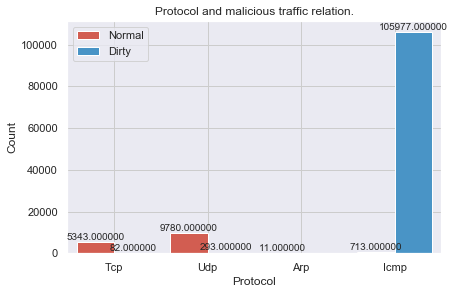

In [16]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Proto", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.set(xticklabels=["Tcp","Udp","Arp","Icmp"])
ax.legend(["Normal","Dirty"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1f}'.format(height),
            ha="center",size=10)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


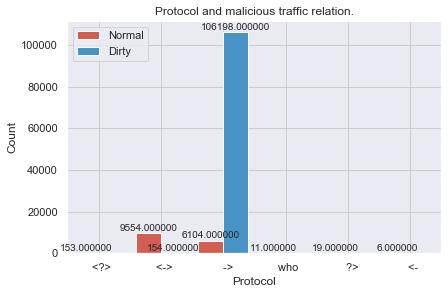

In [17]:
sns.set(rc={'figure.figsize':(6.7,4.27)})
    
flatui = ["#e74c3c","#3498db", "#2ecc71"]
ax = sns.countplot(x="Dir", hue="Label", data=data_vis, palette=flatui)
ax.set_title('Protocol and malicious traffic relation.')
ax.grid(color='#cccccc')
ax.set_ylabel('Count')
ax.set_xlabel('Protocol')
ax.legend(["Normal", "Dirty"])
max_height = 0

for p in ax.patches:
    if p.get_height() > max_height:
        max_height = p.get_height()
    
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
            height + 0.01*max_height,'{:1f}'.format(height),
            ha="center",size=10)

From the below visualisation we can see "Proto" and "Dir" which is already discrete due it being categorical has a major influence on the chance of making a certain record in the netflow data malicious. "State" feature is also very important but the visualisation is not useful due to too many categories. Now returning to the heatmaps of the malicious and normal datasets and observing the correlations for "Proto" and "State" with the other variables, we see that "Proto" has a higher correlation with the "TotBytes" in the malicious dataset than the normal dataset which means, "TotBytes" has a different behaviour for malicious netflows. Similarly, we see the "State" feature has very different correlations with the "Dur" feature between the malicious and normal datasets. With this premise, I believe discretizing the "TotBytes" and "Dur" are going to useful for studying an infected host. 

In [18]:
data_infected_host = data_M.loc[data_M["SrcAddr"]==12]

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn import datasets


In [20]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["Dur"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)

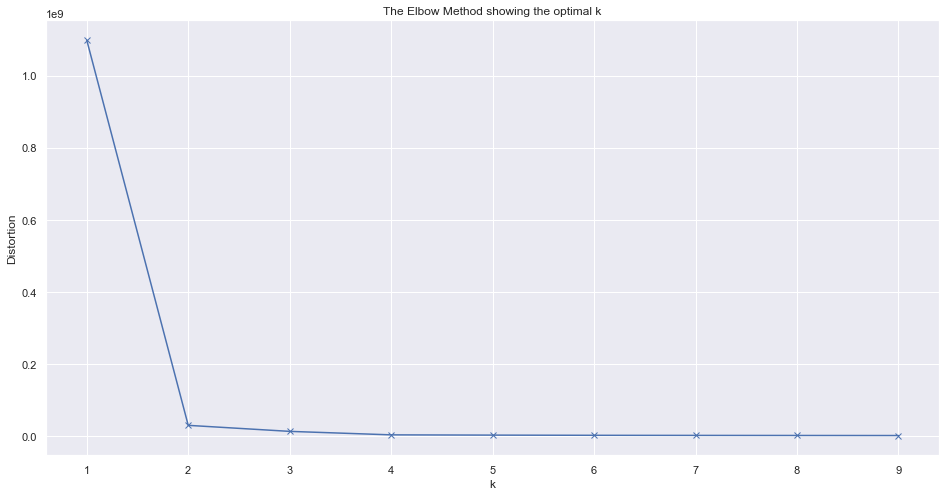

In [21]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the elbow method, the right number of bins for "Dur" feature is 2 but I'm going to try to use 3 just in case.

In [22]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_infected_host["TotBytes"].values.reshape(-1,1))
    distortions.append(kmeanModel.inertia_)

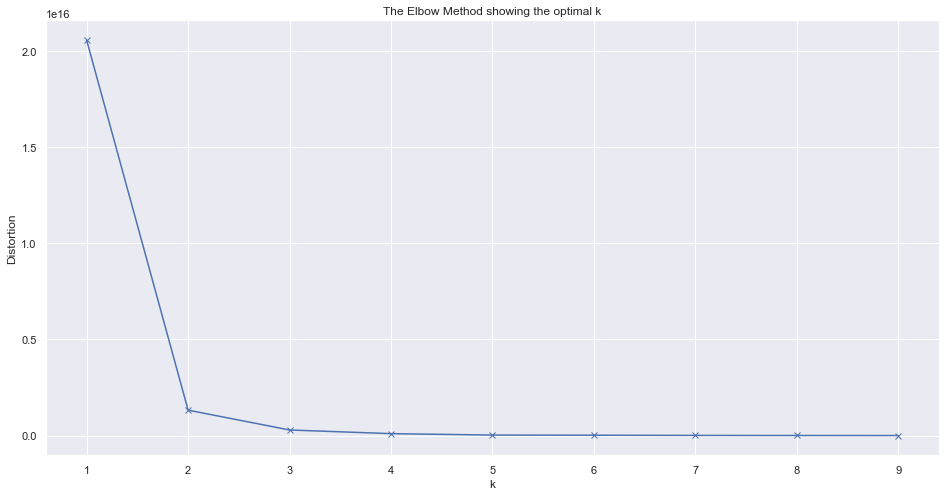

In [23]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Based on the elbow method again, the right number of bins for "TotBytes" feature is 3.

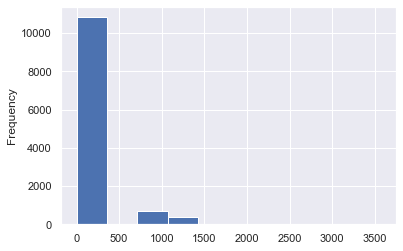

In [26]:
ax=data_infected_host["Dur"].plot(kind="hist")

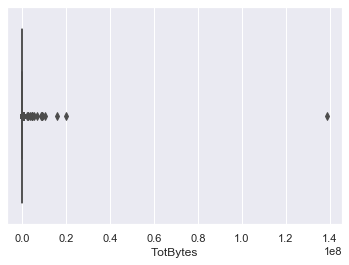

In [27]:
ax=sns.boxplot(data_infected_host["TotBytes"])

There seems to be a great deal of outliers in both features, therefore I must make then a bit more continous by removing outliers to discretize them better. 

In [28]:
#This range isn't right. 
data_infected_host["TotBytes"].min(),data_infected_host["TotBytes"].max()

(60, 138720832)

In [29]:
TotBytes = data_infected_host["TotBytes"].values

In [30]:
#Must see what's wrong.
TotBytes.sort()
for i in TotBytes:
    print(i)

60
60
60
180
180
180
203
203
203
203
460
479
479
479
555
555
555
590
590
590
882
882
882
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1

1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066


1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066


1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066


1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066
1066


37310
37310
37310
37310
37310
37310
37310
37310
37310
38376
38376
38376
38376
38376
38376
38376
38376
38376
38376
38376
38376
38376
38376
38376
38376
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
39442
40508
40508
40508
40508
40508
40508
40508
40508
40508
41574
41574
41574
41574
41574
42640
42640
42640
42640
42640
42640
42640
42640
42640
43706
43706
43706
43706
43706
43706
43706
43706
43706
43706
43706
44772
44772
44772
44772
44772
45246
45838
45838
45838
45838
46904
46904
46904
46904
46904
46904
46904
46904
47970
47970
47970
49036
49036
49036
50102
50102
51168
51168
51168
53300
53300
54366
55432
2305298
2333429
2531304
3646000
4208568
4254406
4285320
4300244
4340752
5398829
6485635
8626072
8750794
8797698
8838206
8908562
10312236
15810245
19679618
138720832


In [31]:
#last 20 values are very large. 
TotBytes_Pure = TotBytes[:-20]

In [32]:
# Getting the outliers to see what they look like for the reviewer.
TotBytes_Outliers=TotBytes[-20:]

In [33]:
#Look at these shameful criminals. 
TotBytes_Outliers

array([  2305298,   2333429,   2531304,   3646000,   4208568,   4254406,
         4285320,   4300244,   4340752,   5398829,   6485635,   8626072,
         8750794,   8797698,   8838206,   8908562,  10312236,  15810245,
        19679618, 138720832], dtype=int64)

In [34]:
#Therefore we have 2 valid intervals based on quantile based discretization and the 3rd will be for the outliers. 
pd.qcut(TotBytes_Pure, q=2)

[(59.999, 1066.0], (59.999, 1066.0], (59.999, 1066.0], (59.999, 1066.0], (59.999, 1066.0], ..., (1066.0, 55432.0], (1066.0, 55432.0], (1066.0, 55432.0], (1066.0, 55432.0], (1066.0, 55432.0]]
Length: 11854
Categories (2, interval[float64]): [(59.999, 1066.0] < (1066.0, 55432.0]]

In [37]:
#Lets discretize the feature TotBytes now. Run this twice to remove the warning. 
data_infected_host.loc[(data_infected_host['TotBytes']>59.99) &(data_infected_host['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_infected_host.loc[(data_infected_host['TotBytes']>1066) &(data_infected_host['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_infected_host.loc[(data_infected_host['TotBytes']>55432),'New_TotBytes'] = 'Level_3'

In [38]:
data_infected_host["New_TotBytes"].unique()

array(['Level_1', 'Level_2', 'Level_3'], dtype=object)

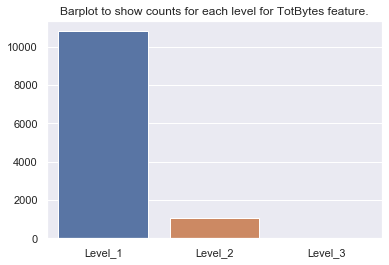

In [39]:
ax=sns.barplot(data_infected_host["New_TotBytes"].value_counts().index,data_infected_host["New_TotBytes"].value_counts().values)
ax.set_title("Barplot to show counts for each level for TotBytes feature.")
plt.show()

In [41]:
# Now doing the same for "Dur" feature. This range doesn't look right. 
data_infected_host["Dur"].min(),data_infected_host["Dur"].max()

(0.0, 3570.946045)

In [42]:
Dur = data_infected_host["Dur"].values

In [43]:
#Very important to sort and look at the kind of values. 
Dur.sort()
for i in Dur:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


1174.1328119999998
1174.168823
1174.186157
1174.9823
1175.000732
1175.491333
1177.544067
1177.824707
1179.030273
1179.066284
1179.422241
1179.720703
1180.725342
1180.736816
1181.0532230000001
1181.2504880000001
1181.288086
1181.631226
1181.8123779999999
1181.9567869999998
1182.216309
1182.258301
1182.3165279999998
1182.335571
1182.3829349999999
1182.4923099999999
1183.095215
1184.1564939999998
1184.282593
1184.451294
1184.568115
1187.470337
1187.9570310000001
1188.254639
1189.5678710000002
1190.008789
1192.581909
1194.797974
1195.3011470000001
1195.4633789999998
1195.7033689999998
1196.09082
1196.282837
1197.485596
1197.648071
1197.8803710000002
1197.915039
1198.092163
1198.649536
1199.174683
1199.588745
1199.799316
1199.864868
1199.981812
1201.22583
1201.230957
1201.2657470000001
1201.7579349999999
1201.873779
1202.0582279999999
1202.134644
1202.29126
1202.619751
1202.7441410000001
1203.5271
1203.601196
1204.618286
1205.591675
1205.638184
1205.799438
1207.229614
1207.31311
1207.475708

In [44]:
# Problem is we cannot get well defined quantiles for such a discontinous array of values. 
#pd.qcut(Dur,2) This doesn't work.
#Based on my sorted list I found these values to be amenable to a valid discretization.  
#0.0 - .17711 - 1
#2.81- 367.652 - 2
#786.85-3570.946045.3 - 3 (I believe these numbers are very large compared to the normal and represent the outliers. Same as before)  

In [45]:
#Lets discretize the feature Dur now.
data_infected_host.loc[(data_infected_host['Dur']>=0.0) &(data_infected_host['Dur']<2.81) ,'New_Dur'] = 'Level_1'
data_infected_host.loc[(data_infected_host['Dur']>2.81) &(data_infected_host['Dur']<786.85) ,'New_Dur'] = 'Level_2'
data_infected_host.loc[(data_infected_host['Dur']>786.85) &(data_infected_host['Dur']<3571.94) ,'New_Dur'] = 'Level_3'

In [46]:
data_infected_host["New_Dur"].unique()

array(['Level_1', 'Level_2', 'Level_3'], dtype=object)

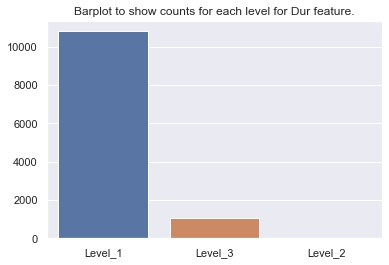

In [47]:
ax=sns.barplot(data_infected_host["New_Dur"].value_counts().index,data_infected_host["New_Dur"].value_counts().values)
ax.set_title("Barplot to show counts for each level for Dur feature.")
plt.show()

Based on this discritization and the barplots of the different levels of the individual features we see that values majorly in the range of level_1 for both "Dur"(0.0-2.81 seconds) and "TotBytes"(66-1066 bytes).

To combine features, the cartesian product of the three levels for each of two feature gives 9 possibilites as shown below-: 


| Dur           | TotBytes      | Combined_Feature |
| ------------- |:-------------:| :---------------:|
| Level_1       |  Level_1      | Combined_Level_1 |
| Level_1       |  Level_2      | Combined_Level_2 |
| Level_1       |  Level_3      | Combined_Level_3 |
| Level_2       |  Level_1      | Combined_Level_4 | 
| Level_2       |  Level_2      | Combined_Level_5 |   
| Level_2       |  Level_3      | Combined_Level_6 | 
| Level_3       |  Level_1      | Combined_Level_7 |
| Level_3       |  Level_2      | Combined_Level_8 |
| Level_3       |  Level_3      | Combined_Level_9 | 


In [48]:
combined_levels=[]
for i,j in zip(data_infected_host["New_Dur"].values,data_infected_host["New_TotBytes"].values):
    if (i=="Level_1") & (j=="Level_1"):
        combined_levels.append("Combined_Level_1")
    elif (i=="Level_1") & (j=="Level_2"):
        combined_levels.append("Combined_Level_2")
    elif (i=="Level_1") & (j=="Level_3"):
        combined_levels.append("Combined_Level_3")
    elif (i=="Level_2") & (j=="Level_1"):
        combined_levels.append("Combined_Level_4")
    elif (i=="Level_2") & (j=="Level_2"):
        combined_levels.append("Combined_Level_5")
    elif (i=="Level_2") & (j=="Level_3"):
        combined_levels.append("Combined_Level_6")
    elif (i=="Level_3") & (j=="Level_1"):
        combined_levels.append("Combined_Level_7")
    elif (i=="Level_3") & (j=="Level_2"):
        combined_levels.append("Combined_Level_8")
    elif (i=="Level_3") & (j=="Level_3"):
        combined_levels.append("Combined_Level_9")
        

In [51]:
data_infected_host.loc[:,"Combined_Levels"]=combined_levels

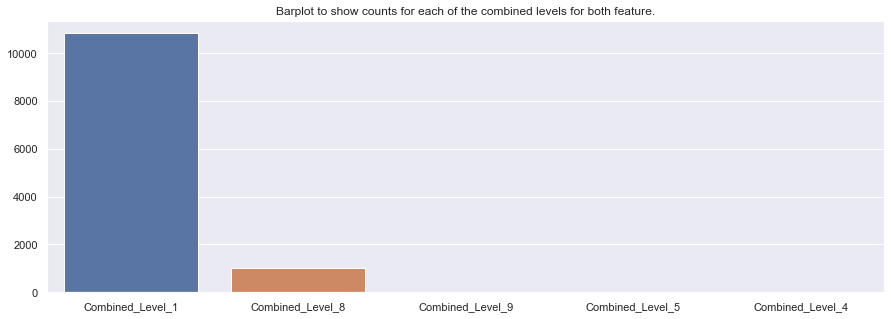

In [52]:
fig,ax= plt.subplots(figsize=(15,5))
ax=sns.barplot(data_infected_host["Combined_Levels"].value_counts().index,data_infected_host["Combined_Levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature.")
plt.show()


Overall, we see that combined_level_1 for this host is quite indicative of malicious activity. This is essentially when Dur and TotBytes level_1s are combined, this is expected ofcourse as they were the most indicative levels for the individual features as well. We then see that combined_level 8 which is a combination of Level_3 from the dur feature and the Level_2 from the TotBytes feature has the second highest frequency.  

In [53]:
#As a final aspect of the first task, we are asked to discretize our chosen features for every host. 
#Therefore I will do the discretization for the entire data_M dataframe.
data_discrete= data_M.copy()
#Lets discretize the feature TotBytes now.
data_discrete.loc[(data_discrete['TotBytes']>59.99) &(data_discrete['TotBytes']<=1066.0) ,'New_TotBytes'] = 'Level_1'
data_discrete.loc[(data_discrete['TotBytes']>1066) &(data_discrete['TotBytes']<=55432) ,'New_TotBytes'] = 'Level_2'
data_discrete.loc[(data_discrete['TotBytes']>55432),'New_TotBytes'] = 'Level_3'
#Lets discretize the feature Dur now.
data_discrete.loc[(data_discrete['Dur']>=0.0) &(data_discrete['Dur']<2.81) ,'New_Dur'] = 'Level_1'
data_discrete.loc[(data_discrete['Dur']>2.81) &(data_discrete['Dur']<786.85) ,'New_Dur'] = 'Level_2'
data_discrete.loc[(data_discrete['Dur']>786.85) &(data_discrete['Dur']<3571.94) ,'New_Dur'] = 'Level_3'

In [54]:
combined_levels_d=[]
for i,j in zip(data_discrete["New_Dur"].values,data_discrete["New_TotBytes"].values):
    if (i=="Level_1") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_1")
    elif (i=="Level_1") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_2")
    elif (i=="Level_1") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_3")
    elif (i=="Level_2") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_4")
    elif (i=="Level_2") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_5")
    elif (i=="Level_2") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_6")
    elif (i=="Level_3") & (j=="Level_1"):
        combined_levels_d.append("Combined_Level_7")
    elif (i=="Level_3") & (j=="Level_2"):
        combined_levels_d.append("Combined_Level_8")
    elif (i=="Level_3") & (j=="Level_3"):
        combined_levels_d.append("Combined_Level_9")

In [55]:
data_discrete= data_discrete.dropna(subset=["New_Dur","New_TotBytes"])

In [57]:
len(combined_levels_d),data_discrete.shape

(106349, (106349, 14))

In [58]:
data_discrete["Combined_levels"] = combined_levels_d

In [62]:
data_discrete["Combined_levels"].value_counts()

Combined_Level_1    96423
Combined_Level_8     9207
Combined_Level_5      482
Combined_Level_9      112
Combined_Level_6       90
Combined_Level_4       35
Name: Combined_levels, dtype: int64

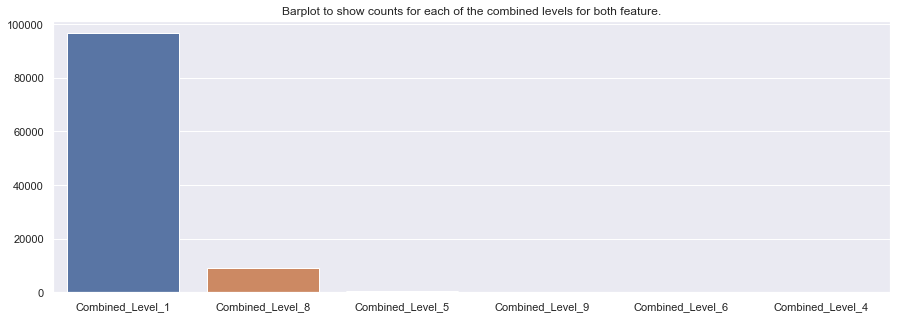

In [61]:
fig,ax= plt.subplots(figsize=(15,5))
ax=sns.barplot(data_discrete["Combined_levels"].value_counts().index,data_discrete["Combined_levels"].value_counts().values)
ax.set_title("Barplot to show counts for each of the combined levels for both feature.")
plt.show()
# This is the end of the first task. 